Download pre-trained Word2Vec model


In [1]:
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

corpus = api.load('text8')
model = Word2Vec(corpus)

[=================================================-] 98.4% 31.1/31.6MB downloaded

Getting embedding of a sentence

In [2]:
import numpy as np

def get_sentence_embedding(model, text):
  # This method takes in the trained model and the input sentence
  # and returns the embedding of the sentence as the average embedding
  # of its words
  words = text.split(" ")
  count = 0
  for i in range(1, len(words)):
    try:
      if count == 0:
        vector = model.wv[words[i]]
      else: 
        vector = np.copy(vector+model.wv[words[i]])
      count+=1
    except:
      continue
  return vector/count

# Sample code to extract vector for a sentence
get_sentence_embedding(model, "test text embedding")

array([-0.08376133, -0.9289037 ,  0.4130277 , -0.5068819 , -0.78874326,
        0.00345826,  0.09388144, -0.32165807, -0.34410477,  0.2013706 ,
        1.0782555 , -1.4301363 , -1.2114264 , -0.8589715 ,  0.15323865,
        1.4254931 ,  2.2975044 , -0.2661055 ,  0.7543904 , -0.9411038 ,
       -1.9477545 , -0.04437305, -0.20690708, -0.59357923, -0.23758967,
        0.60521877, -0.26197624, -2.0989418 , -1.0121778 ,  0.6676285 ,
        0.38765115,  0.07024391, -1.6230764 ,  0.24267915,  0.8533506 ,
        0.9953644 ,  0.37040257,  0.3861176 , -0.17236674,  0.564075  ,
       -0.09787644, -0.77375895,  1.0915526 , -0.04957333,  0.36103123,
        0.3871519 , -0.3388389 , -0.6741001 , -0.691586  , -0.31825435,
        1.0270845 ,  0.877773  , -1.114794  , -0.09082717, -0.31791723,
       -0.42863777, -0.05935358, -0.2540052 , -0.24246345, -0.20529038,
        0.49970686, -0.7222092 ,  0.40263417,  0.26425895,  0.68524355,
       -0.8587611 , -0.13122457,  2.05064   ,  0.19697547,  0.06

Reading TSV file and saving embeddings

In [3]:
import pandas as pd

def read_tweets_get_vectors(tweet_file_path):
  # This method takes in the file path for the twitter file, and return a
  # dicationary of dictionaries. In the first dictionary the keys are the
  # tweet labels (3 classes), and the values are another dictionary with
  # tweet id as the key and values are tuple of (vector, tweet text)
    df = pd.read_csv(tweet_file_path, sep=',', header=0)
    dic_result = {}
    df1 = df[['tweet_id', 'text', 'airline_sentiment']]
    for index in range(len(df1)):
        try:
            vetor_rep = get_sentence_embedding(model, df.loc[index, "text"].lower())
            label = df.loc[index, "airline_sentiment"]
            tweet_id = df.loc[index, "tweet_id"]
            if label in dic_result:
                dic_result[label][tweet_id] = (vetor_rep, df.loc[index, "text"].lower())
            else:
                dic_result[label] = {tweet_id: (vetor_rep, df.loc[index, "text"].lower())}
        except:
            pass
    return dic_result

twitter_data = read_tweets_get_vectors("Tweets.csv")
for key in twitter_data.keys():
  print(key + "\t\t number of instances: " + str(len(twitter_data[key])))

neutral		 number of instances: 3005
positive		 number of instances: 2263
negative		 number of instances: 8997


Code to generate training, validation, and test sets

In [4]:
import random

def split_data(twitter_data):
  # takes in the dictionary from the previous step and generate
  # the training, validation, and test sets. Note that the labels 
  # are represented as one-hot codings.
    training_x = []
    training_y = []

    validation_x = []
    validation_y = []

    test_x = []
    test_y = []

    for label in twitter_data:

        # labels are indicated as one hot coding [negative, neutral, positive]
        if label == "negative":
            n_label = [1, 0, 0]
        elif label == "neutral":
            n_label = [0, 1, 0]
        else:
            n_label = [0, 0, 1]
        temp_dic = twitter_data[label]
        lst_tweet_ids = list(temp_dic.keys())
        #### Splitting by 80-10-10
        ## Note that you could alternatively use sklearn split method
        train_length = int(len(lst_tweet_ids)*0.8)
        train_ids = lst_tweet_ids[ :train_length]
        remaining = lst_tweet_ids[train_length:]
        test_lenght = int(len(remaining)*0.5)
        test_ids = remaining[:test_lenght]
        validation_id = remaining[test_lenght:]

        for tweet_id in train_ids:
            training_x.append(temp_dic[tweet_id][0])
            training_y.append(n_label)
        for tweet_id in validation_id:
            validation_x.append(temp_dic[tweet_id][0])
            validation_y.append(n_label)
        for tweet_id in test_ids:
            test_x.append(temp_dic[tweet_id][0])
            test_y.append(n_label)

    # The reason we apply this shuffling is to make sure 
    # when passing batches to the network, we see different items 
    c = list(zip(training_x, training_y))
    random.shuffle(c)
    training_x, training_y = zip(*c)

    return training_x, training_y, validation_x, validation_y, test_x, test_y

# Sample usage
training_x, training_y, validation_x, validation_y, test_x, test_y = split_data(twitter_data)

Here goes your code for your Feedfoward network Design

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch


class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, p, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Define the neural network layers
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim_1),
            nn.ReLU(),
            nn.Dropout(p),
            #nn.BatchNorm1d(hidden_dim_1),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.ReLU(),
            nn.Dropout(p),
            #nn.BatchNorm1d(hidden_dim_2),
            nn.Linear(hidden_dim_2, hidden_dim_3),
            nn.ReLU(),
            nn.Dropout(p),
            #nn.BatchNorm1d(hidden_dim_3),
            nn.Linear(hidden_dim_3, output_dim)
        )

    def forward(self, x):
        # Your network forward pass
        x = self.layers(x)
        # Sigmoid activation
        out = torch.sigmoid(x)
        return out

In [ ]:
count = 0

Training the network
Define a class, with properties such as size of hidden layers
loss function, optimizer, training method, test method, and accuracy

###FeedForward Neural Network

In [207]:
from tqdm import tqdm

class ModelModule():
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # here goes your parameters
  input_dim = 100
  hidden_dim_1 = 128
  hidden_dim_2 = 64
  hidden_dim_3 = 32
  p = 0.5
  output_dim = 3

  # sample code to define your model 
  model = FeedforwardNeuralNetModel(input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, p, output_dim)
  model.to(device)


  def calculate_accuracy(self, y_true, y_pred):
    # this method will be used to calculate the accuracy of your model
      correct = (y_true.argmax (dim = 1) == y_pred.argmax (dim = 1)).float()
      acc = correct.sum() / len(correct)
      return acc

  def training(self, tfidfX_train, Y_train, tfidfX_val, Y_val, num_epochs):
    global count
    # this method will be used for training your model
    # inputs are the training and validation sets
    Y_train_probs = torch.nn.functional.softmax(Y_train.float(), dim=1)
    # You can define batch size of your choice
    batch_size = 512
    X_train_mini_batches = torch.split(tfidfX_train, batch_size)
    Y_train_mini_batches = torch.split(Y_train, batch_size)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_accuracy = 0
    best_val_loss = float('inf')
    # Define your optimizer (e.g. Adam optimizer with a learning rate of 0.001)
    optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0003, weight_decay= 0.0001)

    # Define your loss function (e.g. Cross Entropy Loss)
    loss_fn = nn.CrossEntropyLoss()

    # Set the model to training mode
    self.model.train()
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0
        epoch_accuracy = 0
        for X_train_mini_batch, Y_train_mini_batch in zip(X_train_mini_batches, Y_train_mini_batches):
            X_train_mini_batch = X_train_mini_batch.to(self.device)
            Y_train_mini_batch = Y_train_mini_batch.to(self.device)

            # Convert integer labels to class probabilities
            Y_train_mini_batch_probs = torch.nn.functional.softmax(Y_train_mini_batch.float(), dim=1)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            y_pred = self.model(X_train_mini_batch)

            # Compute the loss
            loss = loss_fn(y_pred, Y_train_mini_batch_probs)

            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

            # Update the epoch loss and accuracy
            epoch_loss += loss.item()
            epoch_accuracy += self.calculate_accuracy(Y_train_mini_batch_probs, y_pred).item()

        # Compute the average epoch loss and accuracy
        epoch_loss /= len(X_train_mini_batches)
        epoch_accuracy /= len(X_train_mini_batches)

        # Append the training loss and accuracy to their lists
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Evaluate the model on the validation set
        with torch.no_grad():
            # Set the model to evaluation mode
            self.model.eval()

            # Forward pass
            y_val_pred = self.model(tfidfX_val.to(self.device))

            # Convert integer labels to class probabilities
            Y_val_probs = torch.nn.functional.softmax(Y_val.float(), dim=1)

            # Compute the validation loss and accuracy
            val_loss = loss_fn(y_val_pred, Y_val_probs.to(self.device)).item()
            val_accuracy = self.calculate_accuracy(Y_val_probs.to(self.device), y_val_pred).item()

        # Append the validation loss and accuracy to their lists
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save the model if it achieves the best accuracy on the validation set
        if val_accuracy > best_accuracy:
            count = epoch
            torch.save(self.model.state_dict(), 'best_model.pth')
            best_accuracy = val_accuracy
        #if val_loss < best_val_loss:
        #    count = epoch
        #    torch.save(self.model.state_dict(), 'best_model.pth')
        #    best_val_loss = val_loss
    import matplotlib.pyplot as plt
    # Plot the training and validation loss and accuracy
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.show()

    plt.figure()
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.show()

  def predict(self, tfidfX_test):
    # Load the trained model from the saved state dict
    self.model.load_state_dict(torch.load('best_model.pth'))
    self.model.to(self.device)
    
    # Set the model to evaluation mode
    self.model.eval()

    # Forward pass
    with torch.no_grad():
        y_test_pred = self.model(tfidfX_test.to(self.device))

    return y_test_pred
    

100%|██████████| 100/100 [00:06<00:00, 15.49it/s]


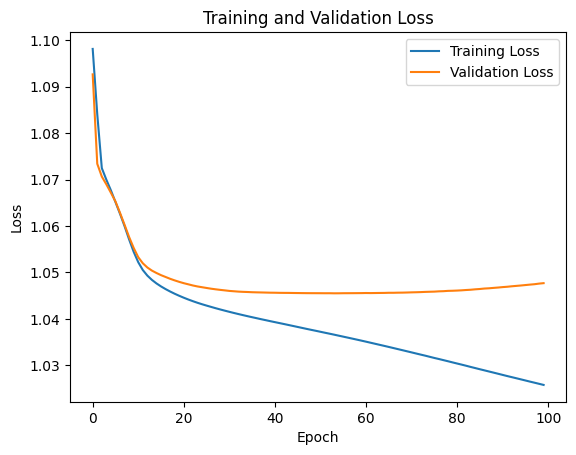

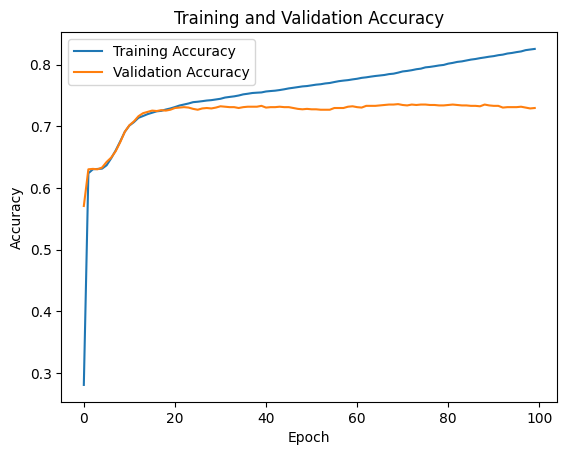

In [208]:
training_x_1d = np.array(training_x)
validation_x_1d = np.array(validation_x)
test_x_1d = np.array(test_x)

training_x_tensor = torch.tensor(training_x_1d )
validation_x_tensor = torch.tensor(validation_x_1d)
test_x_tensor = torch.tensor(test_x_1d)

# Convert labels to tensors
training_y_1d = np.array(training_y)
validation_y_1d = np.array(validation_y)
test_y_1d = np.array(test_y)

training_y_tensor = torch.tensor(training_y_1d)
validation_y_tensor = torch.tensor(validation_y_1d)
test_y_tensor = torch.tensor(test_y_1d)

# Create an instance of your model module
model_module = ModelModule()

# Train the model
model_module.training(training_x_tensor, training_y_tensor, validation_x_tensor, validation_y_tensor, num_epochs=100)



In [209]:
# Test the model
y_test_pred = model_module.predict(test_x_tensor)

# Calculate test accuracy
test_accuracy = model_module.calculate_accuracy(test_y_tensor.to(model_module.device), y_test_pred).item()
print(f"Test accuracy: {test_accuracy}")
print(f"best epoch: {count}")
# Test accuracy: 0.7328190803527832
# best epoch: 69
#input_dim = 100
#hidden_dim_1 = 128
#hidden_dim_2 = 64
#hidden_dim_3 = 32
#p = 0.5
#output_dim = 3
#batch size = 512
#optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0003, weight_decay= 0.0001)


Test accuracy: 0.7328190803527832
best epoch: 69
